# Přísnost známkování na PISA 2018

Odhadni model ve Statě, následně spočítej rezidua v Pythonu a použij je k analýze.

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
#plt.ioff()

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'

In [3]:
sch18, sch18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav')
stu18, stu18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav')

In [4]:
df = stu18[(stu18['ST001D01T'] == 9) & (stu18['STRATUMID_rec'] == 1) & (np.isfinite(stu18['ST800C01HA_CZ'])) & (stu18['ST800C01HA_CZ'] <= 5) & (np.isfinite(stu18['ST800C02HA_CZ'])) & (stu18['ST800C02HA_CZ'] <= 5)].copy()

In [5]:
df.shape

(1878, 724)

In [6]:
df['MATH_MEAN'] = np.mean(df[[f'PV{i}MATH' for i in range(1,11)]], axis=1)
df['READ_MEAN'] = np.mean(df[[f'PV{i}READ' for i in range(1,11)]], axis=1)

In [7]:
df['gr_matematika'] = np.where(df['ST800C01HA_CZ'] < 3, df['ST800C01HA_CZ'], np.where(df['ST800C01HA_CZ'] < 6, 8 - df['ST800C01HA_CZ'], np.nan))
df['gr_cestina'] = df['ST800C02HA_CZ']
df['girl'] = np.int_(df['ST004D01T'] == 1)

```
-------------------------------------------------------------------------------
         math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
--------------+----------------------------------------------------------------
gr_matematika |   -37.9095   2.001885   -18.94   0.000    -41.89963   -33.91937
         girl |  -19.71112   4.504637    -4.38   0.000    -28.81605   -10.60619
         ESCS |   12.77788   2.774707     4.61   0.000     7.284227    18.27154
        _cons |   586.1341   7.172047    81.72   0.000     571.9893    600.2788
-------------------------------------------------------------------------------


------------------------------------------------------------------------------
        read | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
  gr_cestina |  -35.36731   2.665294   -13.27   0.000    -40.60244   -30.13219
        girl |   5.876348   4.055043     1.45   0.149    -2.118508     13.8712
        ESCS |   11.99802   2.814435     4.26   0.000     6.464671    17.53137
       _cons |   549.6907   8.624473    63.74   0.000     532.7707    566.6107
------------------------------------------------------------------------------
```

In [8]:
df['MATH_PRED'] = 586.1341 - 19.71112 * df['girl'] - 37.9095 * df['gr_matematika'] + 12.77788 * df['ESCS']
df['READ_PRED'] = 549.6907 + 5.876348 * df['girl'] - 35.36731 * df['gr_cestina'] + 11.99802 * df['ESCS']

df['MATH_RESID'] = df['MATH_MEAN'] - df['MATH_PRED']
df['READ_RESID'] = df['READ_MEAN'] - df['READ_PRED']

In [9]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [10]:
sch_resid = df.groupby('CNTSCHID')[['MATH_RESID', 'READ_RESID', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')
sch_wr = pd.merge(sch18[['CNTSCHID', 'W_SCHGRNRABWT']], sch_resid.rename(columns={'MATH_RESID': 'MATH_SCHOOL_RESID', 'READ_RESID': 'READ_SCHOOL_RESID'}).reset_index())

In [11]:
dswm = DescrStatsW(sch_wr['MATH_SCHOOL_RESID'], weights=sch_wr['W_SCHGRNRABWT'])
dswr = DescrStatsW(sch_wr['READ_SCHOOL_RESID'], weights=sch_wr['W_SCHGRNRABWT'])

qsm = dswm.quantile([0.2, 0.4, 0.6, 0.8])
qsr = dswr.quantile([0.2, 0.4, 0.6, 0.8])

sch_wr['MATH_SCHOOL_BIN'] = pd.cut(sch_wr['MATH_SCHOOL_RESID'], [-np.inf] + list(qsm) + [np.inf], labels=False)
sch_wr['READ_SCHOOL_BIN'] = pd.cut(sch_wr['READ_SCHOOL_RESID'], [-np.inf] + list(qsr) + [np.inf], labels=False)

In [12]:
df = pd.merge(df, sch_wr)

<AxesSubplot:xlabel='MATH_SCHOOL_RESID', ylabel='READ_SCHOOL_RESID'>

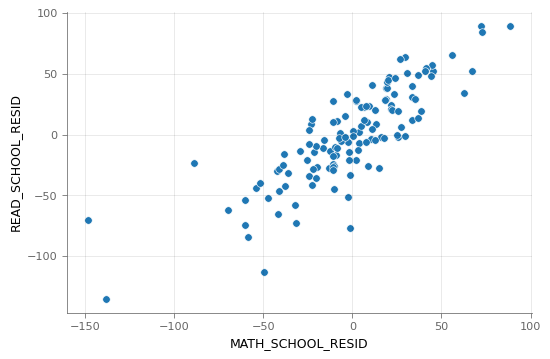

In [13]:
sns.scatterplot(x='MATH_SCHOOL_RESID', y='READ_SCHOOL_RESID', data=sch_wr)

In [14]:
df[['MATH_SCHOOL_RESID', 'READ_SCHOOL_RESID']].corr()

,MATH_SCHOOL_RESID,READ_SCHOOL_RESID
MATH_SCHOOL_RESID,1.000000,0.836531
READ_SCHOOL_RESID,0.836531,1.000000


## Grafy pro studii

Co všechno chci?

Základní deskriptivy
- četnosti známek, kluci vs dívky
- boxplot skóry podle známek (včetně plausible values)
- průměrné skóry podle známek

Pro pět skupin přísnosti známkování:
- četnosti známek
- průměrné skóry podle známek 
- očekávání vystudování VŠ podle známek
- očekávaný status zaměstnání ve 30 podle známek


In [15]:
for i in range(1, 11):
    df[f'math_score_{i}'] = df[f'PV{i}MATH']
dfl = pd.wide_to_long(df, 'math_score', sep='_', j='pv', i=['CNTSTUID'])
df = df.drop(columns=[f'math_score_{i}' for i in range(1, 11)])

[Text(0.5, 0, 'PISA skóre'), Text(0, 0.5, 'Známka')]

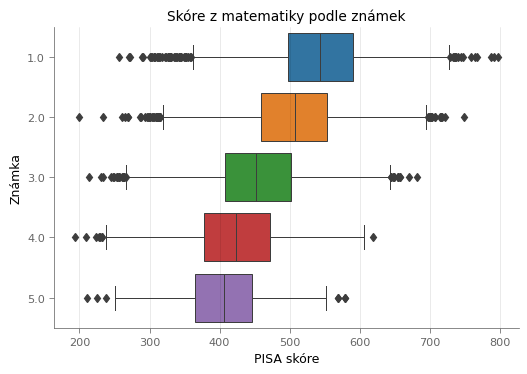

In [17]:
ax = sns.boxplot(y='gr_matematika', x='math_score', data=dfl, orient='h')
ax.set_title('Skóre z matematiky podle známek')
ax.set(xlabel='PISA skóre', ylabel='Známka')

<AxesSubplot:xlabel='gr_matematika', ylabel='W_FSTUWT'>

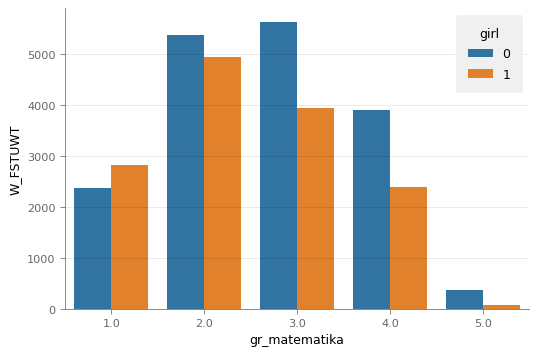

In [22]:
foo = df.groupby(['gr_matematika', 'girl'])['W_FSTUWT'].sum().reset_index()
sns.barplot(x='gr_matematika', y='W_FSTUWT', hue='girl', data=foo)

<AxesSubplot:xlabel='gr_matematika', ylabel='MATH_MEAN'>

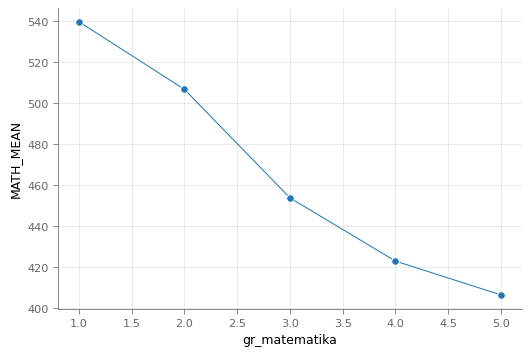

In [26]:
foo = df.groupby('gr_matematika')[['MATH_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, marker='o')

<AxesSubplot:xlabel='gr_matematika', ylabel='MATH_MEAN'>

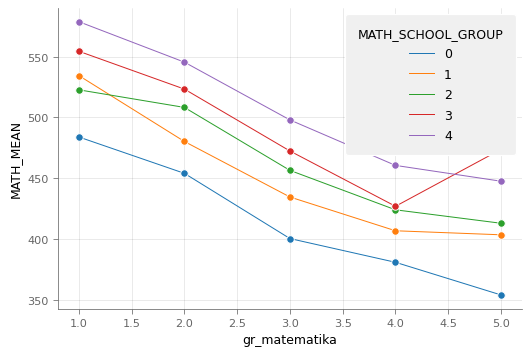

In [29]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_matematika', 'MATH_SCHOOL_BIN'])[['MATH_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['MATH_SCHOOL_GROUP'] = pd.Categorical(foo['MATH_SCHOOL_BIN'])
sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='MATH_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_matematika', ylabel='ST225Q06HA'>

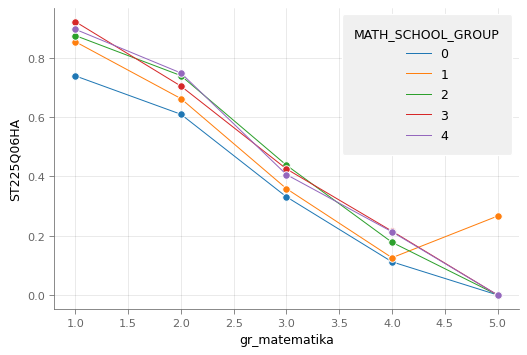

In [30]:
sns.lineplot(x='gr_matematika', y='ST225Q06HA', data=foo, hue='MATH_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_matematika', ylabel='BSMJ'>

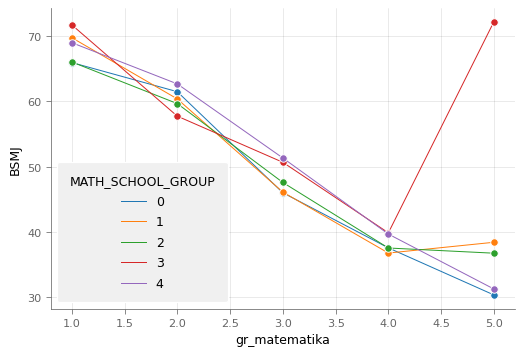

In [31]:
sns.lineplot(x='gr_matematika', y='BSMJ', data=foo, hue='MATH_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_matematika', ylabel='rel_weight'>

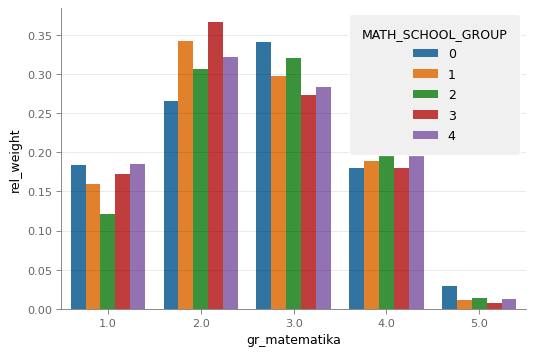

In [34]:
foo = df.groupby(['gr_matematika', 'MATH_SCHOOL_BIN'])['W_FSTUWT'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('MATH_SCHOOL_BIN')['W_FSTUWT'].sum().rename('W_FSTUWT_TOTAL').reset_index())
foo['MATH_SCHOOL_GROUP'] = pd.Categorical(foo['MATH_SCHOOL_BIN'])
foo['rel_weight'] = foo['W_FSTUWT'] / foo['W_FSTUWT_TOTAL']
sns.barplot(x='gr_matematika', y='rel_weight', hue='MATH_SCHOOL_GROUP', data=foo)

## Vypadá to tak i v češtině?

<AxesSubplot:xlabel='gr_cestina', ylabel='W_FSTUWT'>

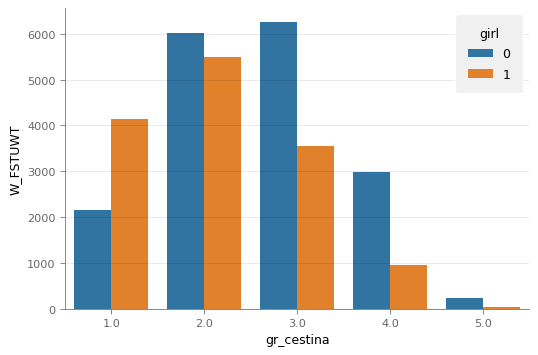

In [35]:
foo = df.groupby(['gr_cestina', 'girl'])['W_FSTUWT'].sum().reset_index()
sns.barplot(x='gr_cestina', y='W_FSTUWT', hue='girl', data=foo)

<AxesSubplot:xlabel='gr_cestina', ylabel='READ_MEAN'>

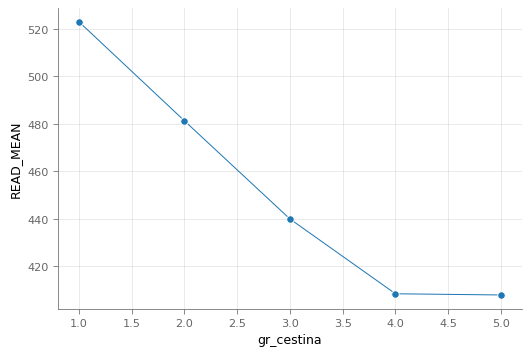

In [36]:
foo = df.groupby('gr_cestina')[['READ_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_cestina', y='READ_MEAN', data=foo, marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='READ_MEAN'>

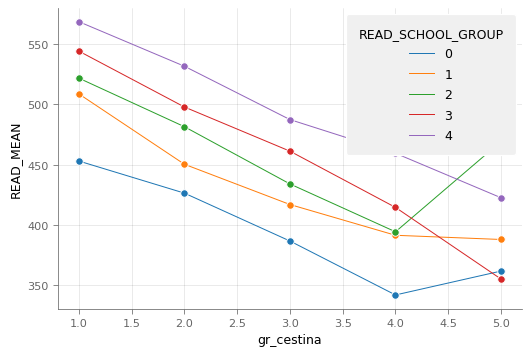

In [37]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_cestina', 'READ_SCHOOL_BIN'])[['READ_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['READ_SCHOOL_GROUP'] = pd.Categorical(foo['READ_SCHOOL_BIN'])
sns.lineplot(x='gr_cestina', y='READ_MEAN', data=foo, hue='READ_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='ST225Q06HA'>

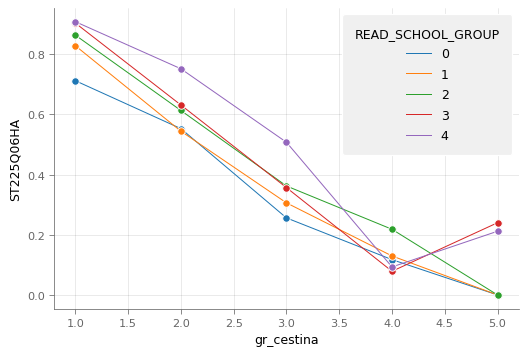

In [38]:
sns.lineplot(x='gr_cestina', y='ST225Q06HA', data=foo, hue='READ_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='BSMJ'>

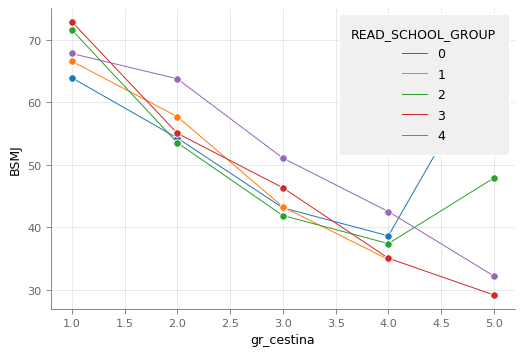

In [39]:
sns.lineplot(x='gr_cestina', y='BSMJ', data=foo, hue='READ_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='rel_weight'>

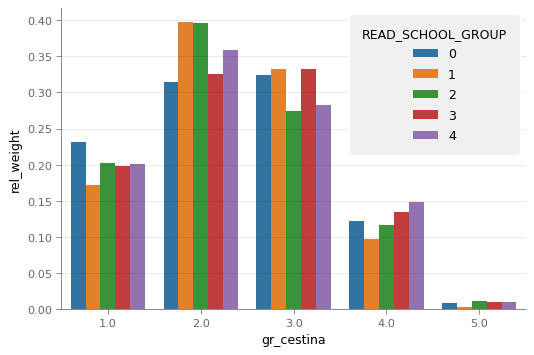

In [40]:
foo = df.groupby(['gr_cestina', 'READ_SCHOOL_BIN'])['W_FSTUWT'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('READ_SCHOOL_BIN')['W_FSTUWT'].sum().rename('W_FSTUWT_TOTAL').reset_index())
foo['READ_SCHOOL_GROUP'] = pd.Categorical(foo['READ_SCHOOL_BIN'])
foo['rel_weight'] = foo['W_FSTUWT'] / foo['W_FSTUWT_TOTAL']
sns.barplot(x='gr_cestina', y='rel_weight', hue='READ_SCHOOL_GROUP', data=foo)

## LHS vs RHS?

Znovu vidím rozdíly podle toho, jestli dám známky na RHS nebo LHS -> gender bias in grading depends on it. To už jsem ale řešil při paperu, ne? Co byl tehdy přesně ten důvod?

In [41]:
df.shape

(1878, 738)

<AxesSubplot:xlabel='gr_matematika', ylabel='MATH_MEAN'>

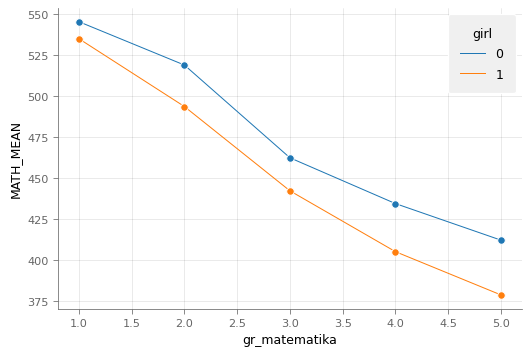

In [45]:
foo = df.groupby(['gr_matematika', 'girl'])[['MATH_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='girl', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='READ_MEAN'>

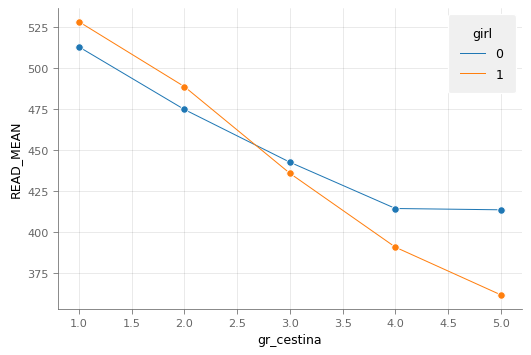

In [46]:
foo = df.groupby(['gr_cestina', 'girl'])[['READ_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_cestina', y='READ_MEAN', data=foo, hue='girl', marker='o')

In [59]:
foo = df.dropna(subset=['ESCS'])
dswe = DescrStatsW(foo['ESCS'], weights=foo['W_FSTUWT'])
df['ESCSz'] = (df['ESCS'] - dswe.mean) / dswe.std
df['ESCS_high'] = df['ESCS'] > 0

In [57]:
dswm = DescrStatsW(df['MATH_MEAN'], weights=df['W_FSTUWT'])
dswr = DescrStatsW(df['READ_MEAN'], weights=df['W_FSTUWT'])

qs = [i / 10 for i in range(1, 10)]
qsm = dswm.quantile(qs)
qsr = dswr.quantile(qs)

df['MATH_BIN'] = pd.cut(df['MATH_MEAN'], [-np.inf] + list(qsm) + [np.inf], labels=False)
df['READ_BIN'] = pd.cut(df['READ_MEAN'], [-np.inf] + list(qsr) + [np.inf], labels=False)

<AxesSubplot:xlabel='MATH_MEAN', ylabel='gr_matematika'>

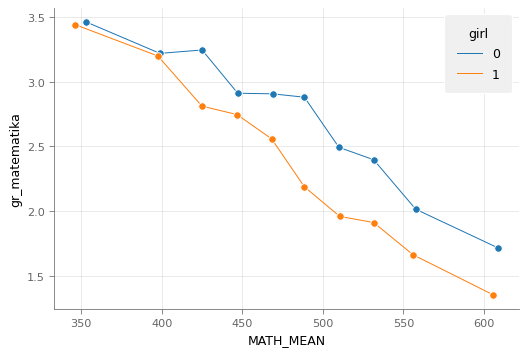

In [58]:
foo = df.groupby(['MATH_BIN', 'girl'])[['MATH_MEAN', 'gr_matematika', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='MATH_MEAN', y='gr_matematika', data=foo, hue='girl', marker='o')

<AxesSubplot:xlabel='READ_MEAN', ylabel='gr_cestina'>

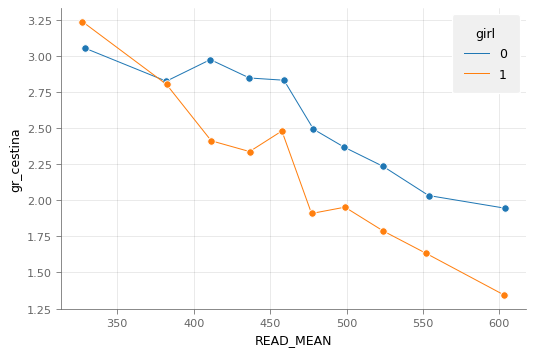

In [60]:
foo = df.groupby(['READ_BIN', 'girl'])[['READ_MEAN', 'gr_cestina', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='READ_MEAN', y='gr_cestina', data=foo, hue='girl', marker='o')

<AxesSubplot:xlabel='MATH_MEAN', ylabel='gr_matematika'>

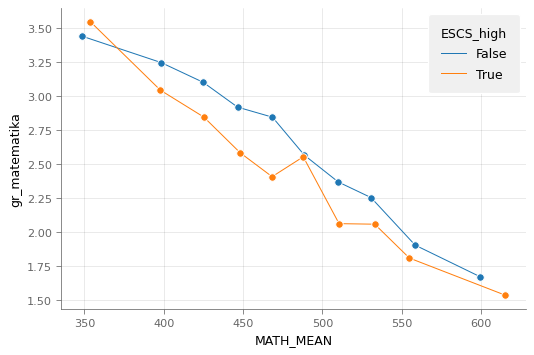

In [61]:
foo = df.groupby(['MATH_BIN', 'ESCS_high'])[['MATH_MEAN', 'gr_matematika', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='MATH_MEAN', y='gr_matematika', data=foo, hue='ESCS_high', marker='o')

<AxesSubplot:xlabel='READ_MEAN', ylabel='gr_cestina'>

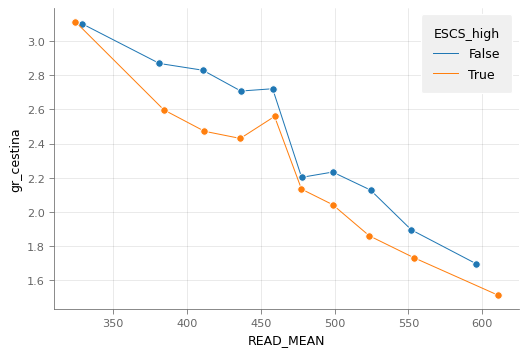

In [62]:
foo = df.groupby(['READ_BIN', 'ESCS_high'])[['READ_MEAN', 'gr_cestina', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='READ_MEAN', y='gr_cestina', data=foo, hue='ESCS_high', marker='o')